In [ ]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
import seaborn as sns
# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)


In [ ]:
# set random seed
np.random.seed(seed=42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = f"/content/drive/My Drive/DCU/Machine Learning/data/data_2025/2025"

In [ ]:
import os
parquet_filenames_train = os.listdir(os.path.join(PATH, 'train'))

In [ ]:
parquet_filenames_train[:3]

['part-00285-of-00362.parquet.parquet',
 'part-00206-of-00362.parquet.parquet',
 'part-00320-of-00362.parquet.parquet']

In [ ]:
f"Number of files in train: {len(parquet_filenames_train):,}"

'Number of files in train: 362'

In [ ]:
parquet_filenames_test = os.listdir(os.path.join(PATH, 'test'))

In [ ]:
parquet_filenames_test[:3]

['part-00109-of-00362.parquet.parquet',
 'part-00092-of-00362.parquet.parquet',
 'part-00123-of-00362.parquet.parquet']

In [ ]:
f"Number of files in test: {len(parquet_filenames_test):,}"

'Number of files in test: 362'

# 1.EDA

## 1.1 Training Dataset

In [ ]:
def read_data(folder, filenames):
    """ Read parquet data from mutiple files """

    dataframes = [
        pd.read_parquet(f"{PATH}/{folder}/{filename}")
        for filename in filenames
    ]

    return pd.concat(dataframes)

In [ ]:
df_train = read_data("train", parquet_filenames_train)

In [ ]:
df_train.shape

(229624, 23)

In [ ]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text']

In [ ]:
df_train.iloc[0]

,0
product_id,1500855633
title,Driftwood Solar Lamp Handcrafted Off Grid Sola...
description,Free shipping in Canada and the USA. This one...
tags,"Driftwood Lamp,driftwood solar,nautical,cottag..."
type,physical
room,patio & outdoor
craft_type,
recipient,
material,wood
occasion,


In [ ]:
df_train.iloc[0][3]

<ipython-input-16-680f671c668e>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_train.iloc[0][3]


'Driftwood Lamp,driftwood solar,nautical,cottage decor,unique,one of a kind,handcrafted,off grid,garden decor,farmhouse decor,house boat decor,solar,garden store'

In [ ]:
df_train['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [ ]:
df_train['room'].unique()

array(['patio & outdoor', '', 'living room', 'entryway', 'game room',
       'craft', 'bedroom', 'office', 'kitchen & dining', 'nursery',
       'kids', 'dorm', 'bathroom', 'laundry', 'bar', 'porch', 'garage',
       'man cave', 'yard'], dtype=object)

In [ ]:
df_train['craft_type'].unique()

array(['', 'party & gifting', "kids' crafts", 'sculpture',
       'printing & printmaking', 'card making & stationery',
       'scrapbooking', 'bookbinding', 'ceramics & pottery', 'collage',
       'woodworking & carpentry', 'beading', 'jewelry making',
       'paper stamping', 'drawing & drafting', 'hat making & hair crafts',
       'floral arranging', 'crochet', 'knitting', 'watchmaking',
       'gardening', 'nail art', 'metalworking', 'sewing', 'quilting',
       'shoemaking', 'leatherworking', 'upholstery', 'photography',
       'needlepoint', 'embroidery', 'crewel', 'cross stitch',
       'electronics & circuitry', 'doll making', 'model making',
       'tatting & lacemaking', 'robotics', 'dollhouses & miniatures',
       'home improvement', 'painting', 'framing', 'coloring',
       '3d printing', 'calligraphy', 'rug making', 'dairy & kombucha',
       'neon art', 'dyeing & batik', 'carving & whittling', 'tattooing',
       'baking', 'stained glass', 'lampworking & shaping', 'candy

In [ ]:
len(df_train['top_category_id'].unique())

15

In [ ]:
len(df_train['top_category_text'].unique())

15

In [ ]:
len(df_train['bottom_category_id'].unique())

2609

In [ ]:
len(df_train['bottom_category_text'].unique())

2609

In [ ]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

<ipython-input-24-32be510a6e5e>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)


,count
top_category_text,
home_and_living,54600
craft_supplies_and_tools,33393
clothing,30143
toys_and_games,13835
accessories,12416
paper_and_party_supplies,12207
bath_and_beauty,11327
weddings,10143
shoes,8892


<ipython-input-25-f28fe1f4d405>:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


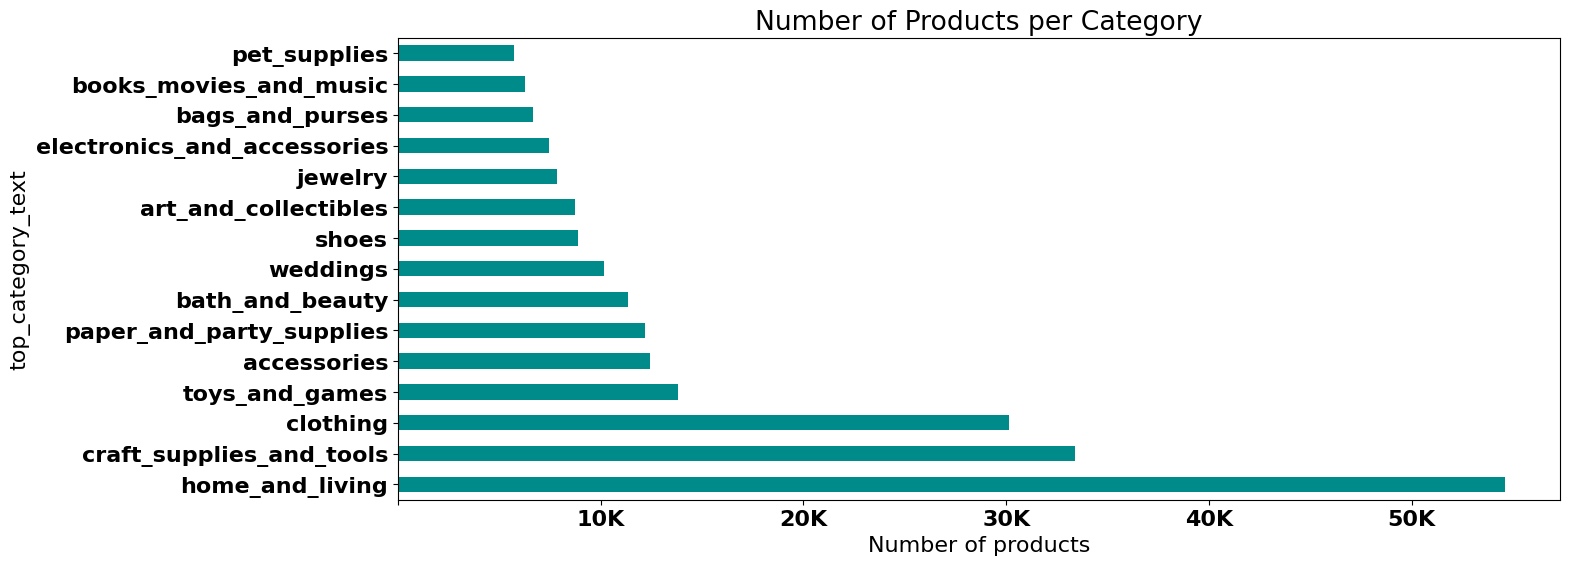

In [ ]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'

figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column],
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [ ]:
df_train.iloc[0][16]

<ipython-input-26-093b03f6b121>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_train.iloc[0][16]


'home_and_living.lighting.light_fixtures.garden_and_string_lights'

In [ ]:
def find_max_category_depth(categories):
    depth = []

    for category in categories:
        # Calculate depth by splitting on '.'
        depth.append(len(category.split('.')))
    max_depth = max(depth)

    return max_depth

def find_min_category_depth(categories):
    depth = []

    for category in categories:
        # if there is "."
        if '.' in category:
            # if exists, append length of "."
            depth.append(len(category.split('.')))
        else:
            # if not exists, apppend 0
            depth.append(0)
            #print(category)

    min_depth = min(depth)

    return min_depth

bottom_categories = df_train['bottom_category_text']
min_depth = find_min_category_depth(bottom_categories)
max_depth = find_max_category_depth(bottom_categories)
# print(f"Maximum depth of bottom categories: {max_depth}")
print(f"Min depth of bottom catories: {min_depth}; Maximum depth of bottom categories: {max_depth}")

Min depth of bottom catories: 0; Maximum depth of bottom categories: 7


## 1.2 Test dataset

The test dataset will be used to predict using the model/s you have trained

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers.

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- **top category id**
- **bottom category id**

The goal is to **maximize F1** for each of the classes on each attribute to predict (top category, bottom category). Your approaches and models will be benchmarked against a hidden test dataset.

**Bonus points** will be given for submissions that:

- **visualize some learned representations or embeddings** and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


In [ ]:
df_test = read_data("test", parquet_filenames_test)

In [ ]:
df_test.shape

(25514, 15)

In [ ]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern']

In [ ]:
df_test.iloc[0]

,0
product_id,1397234990
title,Antler Skull Deer Skull Hand Painted Beads Dec...
description,Hand painted deer antlers.\nThe skull is natur...
tags,
type,physical
room,
craft_type,
recipient,
material,
occasion,


# 2.Preprocessing

## 2.1 With three features
1. title
2. description
3. tags

In [ ]:
import re

# Text preprocessing function
def preprocess_text(text):
   if pd.isna(text):
       return ""
   # Remove HTML tags
   text = re.sub(r'&[a-zA-Z0-9]+;', ' ', text)
   # Remove URLs with www
   text = re.sub(r'www\.[^\s]+', ' ', text)
   # Replace special characters with spaces
   text = re.sub(r'[^\w\s]', ' ', text)
   # Replace multiple spaces with a single space
   text = re.sub(r'\s+', ' ', text)
   return text.lower().strip()

# Feature combination function with three main features
def combine_main_features(row):
    features = []

    columns = ['title', 'description', 'tags']

    for col in columns:
        if not pd.isna(row[col]) and row[col] != '':
            features.append(str(row[col]))

    return ' '.join(features)

# Feature combination function with all features
def combine_all_features(row):
    features = []

    columns = ['title', 'description', 'tags','type', 'room', 'craft_type',
               'recipient', 'material', 'occasion', 'holiday',
               'art_subject', 'style', 'shape', 'pattern']

    for col in columns:
        if not pd.isna(row[col]) and row[col] != '':
            features.append(str(row[col]))

    return ' '.join(features)

In [ ]:
df_train['three_features'] = df_train.apply(combine_main_features, axis=1)
df_train['processed_text_three'] = df_train['three_features'].apply(preprocess_text)
df_train['all_features'] = df_train.apply(combine_all_features, axis=1)
df_train['processed_text_all'] = df_train['all_features'].apply(preprocess_text)

In [ ]:
df_train.iloc[0]

,0
product_id,1500855633
title,Driftwood Solar Lamp Handcrafted Off Grid Sola...
description,Free shipping in Canada and the USA. This one...
tags,"Driftwood Lamp,driftwood solar,nautical,cottag..."
type,physical
room,patio & outdoor
craft_type,
recipient,
material,wood
occasion,


In [ ]:
df_train.iloc[0][-1]

<ipython-input-35-fa648131a1e0>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_train.iloc[0][-1]


'driftwood solar lamp handcrafted off grid solar night light garden driftwood solar light gazebo light sleep camp light free shipping in canada and the usa this one of a kind solar driftwood lamp is ready for any setting such as a garden cottage sun room sleep camp off grid and any nautical decor it is 15 5 inches tall by 10 inches long absolutely beautiful piece of artwork if you have any questions please feel free to contact me anytime driftwood lamp driftwood solar nautical cottage decor unique one of a kind handcrafted off grid garden decor farmhouse decor house boat decor solar garden store physical patio outdoor wood'

In [ ]:
df_train.iloc[0][-3]

<ipython-input-36-3352bac63f59>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_train.iloc[0][-3]


'driftwood solar lamp handcrafted off grid solar night light garden driftwood solar light gazebo light sleep camp light free shipping in canada and the usa this one of a kind solar driftwood lamp is ready for any setting such as a garden cottage sun room sleep camp off grid and any nautical decor it is 15 5 inches tall by 10 inches long absolutely beautiful piece of artwork if you have any questions please feel free to contact me anytime driftwood lamp driftwood solar nautical cottage decor unique one of a kind handcrafted off grid garden decor farmhouse decor house boat decor solar garden store'

In [ ]:
df_train['top_category_target'] = '__label__' + df_train['top_category_id'].astype(str)

In [ ]:
df_train['description1_to_target'] = df_train['top_category_target'] + " " + df_train['processed_text_three']
df_train['description2_to_target'] = df_train['top_category_target'] + " " + df_train['processed_text_all']

In [ ]:
df_train.iloc[0]

,0
product_id,1500855633
title,Driftwood Solar Lamp Handcrafted Off Grid Sola...
description,Free shipping in Canada and the USA. This one...
tags,"Driftwood Lamp,driftwood solar,nautical,cottag..."
type,physical
room,patio & outdoor
craft_type,
recipient,
material,wood
occasion,


In [ ]:
df_train['description1_to_target'].iloc[0]

'__label__8 driftwood solar lamp handcrafted off grid solar night light garden driftwood solar light gazebo light sleep camp light free shipping in canada and the usa this one of a kind solar driftwood lamp is ready for any setting such as a garden cottage sun room sleep camp off grid and any nautical decor it is 15 5 inches tall by 10 inches long absolutely beautiful piece of artwork if you have any questions please feel free to contact me anytime driftwood lamp driftwood solar nautical cottage decor unique one of a kind handcrafted off grid garden decor farmhouse decor house boat decor solar garden store'

In [ ]:
df_train['description2_to_target'].iloc[0]

'__label__8 driftwood solar lamp handcrafted off grid solar night light garden driftwood solar light gazebo light sleep camp light free shipping in canada and the usa this one of a kind solar driftwood lamp is ready for any setting such as a garden cottage sun room sleep camp off grid and any nautical decor it is 15 5 inches tall by 10 inches long absolutely beautiful piece of artwork if you have any questions please feel free to contact me anytime driftwood lamp driftwood solar nautical cottage decor unique one of a kind handcrafted off grid garden decor farmhouse decor house boat decor solar garden store physical patio outdoor wood'

## 2.2 Split data as train and test dataset
1. Combined text with three columns
2. Combined text with all columns

In [ ]:
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

# Split training/validation data
train, val = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train['top_category_id'],
    random_state=42
)

print(f"Training data size: {len(train)}")
print(f"Validation data size: {len(val)}")

Training data size: 183699
Validation data size: 45925


In [ ]:
train.to_csv("/content/drive/My Drive/DCU/Machine Learning/three_columns.train", columns=['description1_to_target'], index=False, header=False)
val.to_csv("/content/drive/My Drive/DCU/Machine Learning/three_columns.val", columns=['description1_to_target'], index=False, header=False)
train.to_csv("/content/drive/My Drive/DCU/Machine Learning/all_columns.train", columns=['description2_to_target'], index=False, header=False)
val.to_csv("/content/drive/My Drive/DCU/Machine Learning/all_columns.val", columns=['description2_to_target'], index=False, header=False)

# 3.Train Model

In [ ]:
pip install fasttext

In [ ]:
import fasttext

model = fasttext.train_supervised(
    input='/content/drive/My Drive/DCU/Machine Learning/three_columns.train'
)

In [ ]:
model.test('/content/drive/My Drive/DCU/Machine Learning/three_columns.val')

(45925, 0.8509961894393032, 0.8509961894393032)

In [ ]:
model2 = fasttext.train_supervised(
    input='/content/drive/My Drive/DCU/Machine Learning/all_columns.train'
)

In [ ]:
model2.test('/content/drive/My Drive/DCU/Machine Learning/all_columns.val')

(45925, 0.8613826891671204, 0.8613826891671204)

In [ ]:
result = model2.test('/content/drive/My Drive/DCU/Machine Learning/all_columns.val')

In [ ]:
def calculate_f1(precision, recall):
    if precision + recall == 0:
        return 0  # Avoid division by zero
    return 2 * (precision * recall) / (precision + recall)

# Example usage
precision = result[1]
recall = result[2]
f1 = calculate_f1(precision, recall)
print(f"F1 Score: {f1}")

F1 Score: 0.8613826891671204


In [ ]:
model3 = fasttext.train_supervised(
    input='/content/drive/My Drive/DCU/Machine Learning/all_columns.train',
    lr = 1.5,
    dim = 70,
    epoch = 6,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'

)

In [ ]:
model3.test('/content/drive/My Drive/DCU/Machine Learning/all_columns.val')

(45925, 0.8994011976047904, 0.8994011976047904)

In [ ]:
model4 = fasttext.train_supervised(
    input='/content/drive/My Drive/DCU/Machine Learning/all_columns.train',
    lr = 1.5,
    dim = 80,
    epoch = 6,
    ws = 6,
    loss='ova',
    wordNgrams = 3

)

In [ ]:
model4.test('/content/drive/My Drive/DCU/Machine Learning/all_columns.val')

(45925, 0.899270549809472, 0.899270549809472)

In [ ]:
#predictions = model3.predict("kind handcrafted off grid g", k=1)
model3.predict(["kind handcrafted off grid g  and any nautical decor it is 15 5 inches tall by 10 inches long absolutely beautiful piece of art"], k=1)

([['__label__10']], [array([0.06188598], dtype=float32)])

# 4.Building metrics function for models
> Since test funnction in fasttest does not provide precision and recall in each category, so udf metrics function required.

In [ ]:
from collections import defaultdict
test_file = "/content/drive/My Drive/DCU/Machine Learning/all_columns.val"

true_positives = defaultdict(int)
false_positives = defaultdict(int)
false_negatives = defaultdict(int)
total_by_category = defaultdict(int)

with open(test_file, 'r', encoding='utf-8') as f:
       for line in f:
           line = line.strip()
           if not line:
               continue

           # Split label and text each line in test file
           parts = line.split(' ', 1)
           if len(parts) < 2:
               continue

           true_label = parts[0].replace('__label__', '')   # '5'
           text = parts[1]      # 'text'

           predictions = model3.predict([text], k=1)    # ([['__label__5']], [array([0.9972091], dtype=float32)])
           predicted_label = predictions[0][0][0].replace('__label__', '')   # '5'

           total_by_category[true_label] += 1

           # Update accuracy metrics
           if predicted_label == true_label:
               true_positives[true_label] += 1
           else:
               false_positives[predicted_label] += 1 # if predicted_label different from true_label, then count of false postive will increase
               false_negatives[true_label] += 1

# Calculate results
categories = sorted(total_by_category.keys())
results = []
for category in categories:
# Calculate precision, recall, F1
  tp = true_positives[category]
  fp = false_positives[category]
  fn = false_negatives[category]
  total = total_by_category[category]

  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

  results.append({
      'category': category,
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'support': total
      })

In [ ]:
# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

,category,precision,recall,f1,support
0,0,0.851521,0.845348,0.848424,2483
1,1,0.816092,0.692484,0.749224,1743
2,10,0.859992,0.865274,0.862625,2442
3,11,0.932735,0.905135,0.918728,1149
4,12,0.971894,0.972441,0.972168,1778
5,13,0.894816,0.860860,0.877510,2767
6,14,0.800446,0.707738,0.751242,2029
7,2,0.866318,0.872180,0.869239,1330
8,3,0.914465,0.901545,0.907959,2265
9,4,0.908720,0.890575,0.899556,1252


In [ ]:
# Calculate weighted average
weighted_sum_p = (df_results['precision'] * df_results['support']).sum()
weighted_sum_r = (df_results['recall'] * df_results['support']).sum()
weighted_sum_f1 = (df_results['f1'] * df_results['support']).sum()
total_support = df_results['support'].sum()

weighted_avg = {
       'category': 'weighted avg',
       'precision': weighted_sum_p / total_support if total_support > 0 else 0,
       'recall': weighted_sum_r / total_support if total_support > 0 else 0,
       'f1': weighted_sum_f1 / total_support if total_support > 0 else 0,
       'support': total_support
   }

df_results = pd.concat([df_results, pd.DataFrame([weighted_avg])], ignore_index=True)

In [ ]:
df_results

,category,precision,recall,f1,support
0,0,0.851521,0.845348,0.848424,2483
1,1,0.816092,0.692484,0.749224,1743
2,10,0.859992,0.865274,0.862625,2442
3,11,0.932735,0.905135,0.918728,1149
4,12,0.971894,0.972441,0.972168,1778
5,13,0.894816,0.860860,0.877510,2767
6,14,0.800446,0.707738,0.751242,2029
7,2,0.866318,0.872180,0.869239,1330
8,3,0.914465,0.901545,0.907959,2265
9,4,0.908720,0.890575,0.899556,1252


In [ ]:
df_train.loc[df_train['top_category_id'] == 1].iloc[0]

,0
product_id,1492865514
title,Handpainted Needlepoint Canvas Believe Snowman...
description,K & M Hammerschmidt for CBK\nMeasures: approx....
tags,"18 count,winter needlepoint,hand painted canvas"
type,physical
room,
craft_type,
recipient,
material,
occasion,


In [ ]:
total_by_category[true_label] += 1

In [ ]:
val['top_category_text'].value_counts()

,count
top_category_text,
home_and_living,10920
craft_supplies_and_tools,6679
clothing,6029
toys_and_games,2767
accessories,2483
paper_and_party_supplies,2442
bath_and_beauty,2265
weddings,2029
shoes,1778


In [ ]:
total_by_category

defaultdict(int,
            {'13': 2767,
             '10': 2442,
             '8': 10920,
             '7': 1495,
             '6': 6679,
             '14': 2029,
             '5': 6030,
             '3': 2265,
             '9': 1564,
             '4': 1252,
             '12': 1778,
             '11': 1149,
             '1': 1743,
             '2': 1330,
             '0': 2483})

In [ ]:
true_positives

defaultdict(int,
            {'13': 2382,
             '10': 2113,
             '8': 10283,
             '7': 1345,
             '6': 6130,
             '14': 1436,
             '5': 5815,
             '3': 2042,
             '4': 1115,
             '12': 1729,
             '1': 1207,
             '0': 2099,
             '11': 1040,
             '9': 1409,
             '2': 1160})

In [ ]:
false_positives

defaultdict(int,
            {'12': 50,
             '8': 1229,
             '13': 280,
             '1': 272,
             '5': 329,
             '9': 193,
             '7': 113,
             '14': 358,
             '2': 179,
             '0': 366,
             '6': 529,
             '10': 344,
             '3': 191,
             '4': 112,
             '11': 75})

In [ ]:
text

'luminous oracle kimono white gold mesh festival kimono robe with hood burning man cosplay costume beautiful lightweight white mesh kimono embellished with golden white lights and trimmed with an elegant metallic golden ribbon featuring a diamond motif made from soft flowing white mesh features an oversized hood that can be worn pulled down over the face for a mysterious look n na versatile outfit that can be worn as a beach cover up lingerie or festival costume each sleeve has a string of leds and battery pack the kimono is hand washable however the battery packs must be kept away from the water n nunisex sizes n s m 36 chest or smaller n m l up to 40 chest n l xl up to 42 chest n xxl up to 45 chest n nalso available in black separate listing n ndue to etsy 39 s shipping requirements the cr 2032 coin cell batteries for the leds are not included but you will given ordering and installation instructions for them after purchase burning man costume led costume led clothing festival costum

In [ ]:
true_label

'5'

In [ ]:
predictions

([['__label__5']], [array([0.9972091], dtype=float32)])

In [ ]:
type(predictions[0][0][0].replace('__label__', ""))

str

In [ ]:
sorted(total_by_category.keys())

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [ ]:
def evaluate_fasttext_by_category(model, test_file):
   """
   Calculate precision, recall, f1 score for each category in a FastText model.

   Args:
       model: Trained FastText model
       test_file: Path to test file in FastText format (__label__category text)

   Returns:
       DataFrame: Performance metrics by category
   """

   from collections import defaultdict

   # Counters to track TP, FP, FN for each category
   true_positives = defaultdict(int)
   false_positives = defaultdict(int)
   false_negatives = defaultdict(int)
   total_by_category = defaultdict(int)

   # Read test file
   with open(test_file, 'r', encoding='utf-8') as f:
       for line in f:
           line = line.strip()
           if not line:
               continue

           # Split label and text
           parts = line.split(' ', 1)
           if len(parts) < 2:
               continue

           true_label = parts[0].replace('__label__', '')
           text = parts[1]

           # Make prediction
           predictions = model.predict([text], k=1)
           predicted_label = predictions[0][0][0].replace('__label__', '')

           # Increment actual category count
           total_by_category[true_label] += 1

           # Update accuracy metrics
           if predicted_label == true_label:
               true_positives[true_label] += 1
           else:
               false_positives[predicted_label] += 1
               false_negatives[true_label] += 1

    # Calculate results
   categories = sorted(total_by_category.keys())
   results = []

   for category in categories:
       # Calculate precision, recall, F1
       tp = true_positives[category]
       fp = false_positives[category]
       fn = false_negatives[category]
       total = total_by_category[category]

       precision = tp / (tp + fp) if (tp + fp) > 0 else 0
       recall = tp / (tp + fn) if (tp + fn) > 0 else 0
       f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

       results.append({
           'category': category,
           'precision': precision,
           'recall': recall,
           'f1': f1,
           'support': total
       })
   # Convert to DataFrame
   df_results = pd.DataFrame(results)

   # Calculate weighted average
   weighted_sum_p = (df_results['precision'] * df_results['support']).sum()
   weighted_sum_r = (df_results['recall'] * df_results['support']).sum()
   weighted_sum_f1 = (df_results['f1'] * df_results['support']).sum()
   total_support = df_results['support'].sum()
   weighted_avg = {
       'category': 'weighted avg',
       'precision': weighted_sum_p / total_support if total_support > 0 else 0,
       'recall': weighted_sum_r / total_support if total_support > 0 else 0,
       'f1': weighted_sum_f1 / total_support if total_support > 0 else 0,
       'support': total_support
   }
   df_results = pd.concat([df_results, pd.DataFrame([weighted_avg])], ignore_index=True)

   return df_results

In [ ]:
evaluate_fasttext_by_category(model, test_file)

,category,precision,recall,f1,support
0,0,0.810811,0.773258,0.791589,2483
1,1,0.736357,0.596099,0.658846,1743
2,10,0.808657,0.818591,0.813594,2442
3,11,0.931966,0.870322,0.900090,1149
4,12,0.963938,0.947132,0.955461,1778
5,13,0.863794,0.811348,0.836750,2767
6,14,0.708831,0.585510,0.641296,2029
7,2,0.825949,0.784962,0.804934,1330
8,3,0.886175,0.849007,0.867193,2265
9,4,0.871649,0.857029,0.864277,1252


In [ ]:
evaluate_fasttext_by_category(model2, test_file)

,category,precision,recall,f1,support
0,0,0.803419,0.795006,0.799190,2483
1,1,0.749829,0.627653,0.683323,1743
2,10,0.831592,0.814906,0.823164,2442
3,11,0.934884,0.874674,0.903777,1149
4,12,0.959207,0.952193,0.955687,1778
5,13,0.856285,0.824720,0.840206,2767
6,14,0.704425,0.588467,0.641246,2029
7,2,0.806213,0.819549,0.812826,1330
8,3,0.889450,0.856071,0.872441,2265
9,4,0.873676,0.856230,0.864865,1252


In [ ]:
evaluate_fasttext_by_category(model3, test_file)

,category,precision,recall,f1,support
0,0,0.851521,0.845348,0.848424,2483
1,1,0.816092,0.692484,0.749224,1743
2,10,0.859992,0.865274,0.862625,2442
3,11,0.932735,0.905135,0.918728,1149
4,12,0.971894,0.972441,0.972168,1778
5,13,0.894816,0.860860,0.877510,2767
6,14,0.800446,0.707738,0.751242,2029
7,2,0.866318,0.872180,0.869239,1330
8,3,0.914465,0.901545,0.907959,2265
9,4,0.908720,0.890575,0.899556,1252


In [ ]:
evaluate_fasttext_by_category(model4, test_file)

,category,precision,recall,f1,support
0,0,0.857957,0.848973,0.853441,2483
1,1,0.820461,0.694779,0.752408,1743
2,10,0.863413,0.861998,0.862705,2442
3,11,0.933453,0.903394,0.918178,1149
4,12,0.969118,0.970754,0.969935,1778
5,13,0.874589,0.864474,0.869502,2767
6,14,0.804409,0.701331,0.749342,2029
7,2,0.868124,0.866165,0.867143,1330
8,3,0.915132,0.899779,0.907391,2265
9,4,0.910948,0.890575,0.900646,1252


In [ ]:
model3.save_model('/content/drive/My Drive/DCU/Machine Learning/top_category_best.bin')

# 5.Visulization
* From the weighted avg f1, we can see that model3, which is represented by 70 vectors, is the best so far.
* At visulization stage, my approach is using pca to reduce dimension from 70 to 2, and comparing how different between actual label and predicted label.


## 5.1 PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
test_file = "/content/drive/My Drive/DCU/Machine Learning/all_columns.val"

In [ ]:
# 1. Extract texts and labels from test file
def load_test_data(test_file):
   texts = []
   true_labels = []
   predicted_labels = []

   with open(test_file, 'r', encoding='utf-8') as f:
       for line in f:
           line = line.strip()
           if not line:
               continue

           parts = line.split(' ', 1)
           if len(parts) < 2:
               continue

           true_label = parts[0].replace('__label__', '')
           text = parts[1]

           texts.append(text)
           true_labels.append(true_label)

           # Make prediction
           predictions = model.predict([text], k=1)
           predicted_label = predictions[0][0][0].replace('__label__', '')
           predicted_labels.append(predicted_label)

   return texts, true_labels, predicted_labels

In [ ]:
texts = load_test_data(test_file)[0]

In [ ]:
true_labels = load_test_data(test_file)[1]
predicted_labels = load_test_data(test_file)[2]

In [ ]:
len(true_labels), len(predicted_labels)

(45925, 45925)

In [ ]:
# 2. Convert texts to vectors
def get_text_vectors(model, texts):
   vectors = []
   for text in texts:
       # Get sentence vector from FastText model
       vector = model.get_sentence_vector(text)
       vectors.append(vector)
   return np.array(vectors)

In [ ]:
vector = get_text_vectors(model3, texts)

In [ ]:
vector.shape

(45925, 70)

In [ ]:
# 3. Reduce dimensions using PCA
def reduce_dimensions(vectors, n_components=3):
   pca = PCA(n_components=n_components)
   reduced_vectors = pca.fit_transform(vectors)

   # Explained variance ratio for each principal component
   print(f"PCA1 explained variance ratio: {pca.explained_variance_ratio_[0]:.4f}")
   print(f"PCA2 explained variance ratio: {pca.explained_variance_ratio_[1]:.4f}")
   print(f"PCA3 explained variance ratio: {pca.explained_variance_ratio_[2]:.4f}")
   print(f"Total explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

   return reduced_vectors, pca

In [ ]:
vectors_3d = reduce_dimensions(vector)

PCA1 explained variance ratio: 0.2690
PCA2 explained variance ratio: 0.1930
PCA3 explained variance ratio: 0.1110
Total explained variance ratio: 0.5730


In [ ]:
reduced_vectors = vectors_3d[0]

In [ ]:
reduced_vectors

array([[ 0.0075243 ,  0.09488332, -0.15377682],
       [-0.36734182, -0.01076876, -0.05629672],
       [-0.3035785 ,  0.21964109,  0.15384758],
       ...,
       [ 0.16793184,  0.00205265, -0.15060641],
       [ 0.00203086,  0.13566042, -0.1200708 ],
       [ 0.47981095, -0.42859513,  0.0820682 ]], dtype=float32)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("Predicted Top Labels", "Actual Top Labels")
)

# First subplot - Predicted Labels
unique_labels_pred = sorted(set(predicted_labels))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_pred)))
colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b, _ in colors]

for i, label in enumerate(unique_labels_pred):
    indices = [j for j, l in enumerate(predicted_labels) if l == label]
    if indices:
        points = reduced_vectors[indices]
        fig.add_trace(
            go.Scatter3d(
                x=points[:, 0], y=points[:, 1], z=points[:, 2],
                mode='markers',
                marker=dict(
                    color=colors[i],
                    size=5,  # Fixed size for all markers
                    opacity=0.7
                ),
                name=label
            ),
            row=1, col=1
        )

# Second subplot - True Labels
unique_labels_true = sorted(set(true_labels))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_true)))
colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b, _ in colors]

for i, label in enumerate(unique_labels_true):
    indices = [j for j, l in enumerate(true_labels) if l == label]
    if indices:
        points = reduced_vectors[indices]
        fig.add_trace(
            go.Scatter3d(
                x=points[:, 0], y=points[:, 1], z=points[:, 2],
                mode='markers',
                marker=dict(
                    color=colors[i],
                    size=5,  # Fixed size for all markers
                    opacity=0.7
                ),
                name=label
            ),
            row=1, col=2
        )

# Update layout with fixed axes ranges
fig.update_layout(
    height=800, width=1600,
    scene=dict(
        xaxis=dict(range=[-4, 4], autorange=False),
        yaxis=dict(range=[-4, 4], autorange=False),
        zaxis=dict(range=[-4, 4], autorange=False)
    ),
    scene2=dict(
        xaxis=dict(range=[-4, 4], autorange=False),
        yaxis=dict(range=[-4, 4], autorange=False),
        zaxis=dict(range=[-4, 4], autorange=False)
    )
)

# Save as HTML file for interactive viewing
fig.write_html('/content/drive/My Drive/DCU/Machine Learning/top_labels_comparison_3d.html')

# Show plot in notebook
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## 5.2 Plotting Actual category VS Predicted category based on reduced 2D dimension

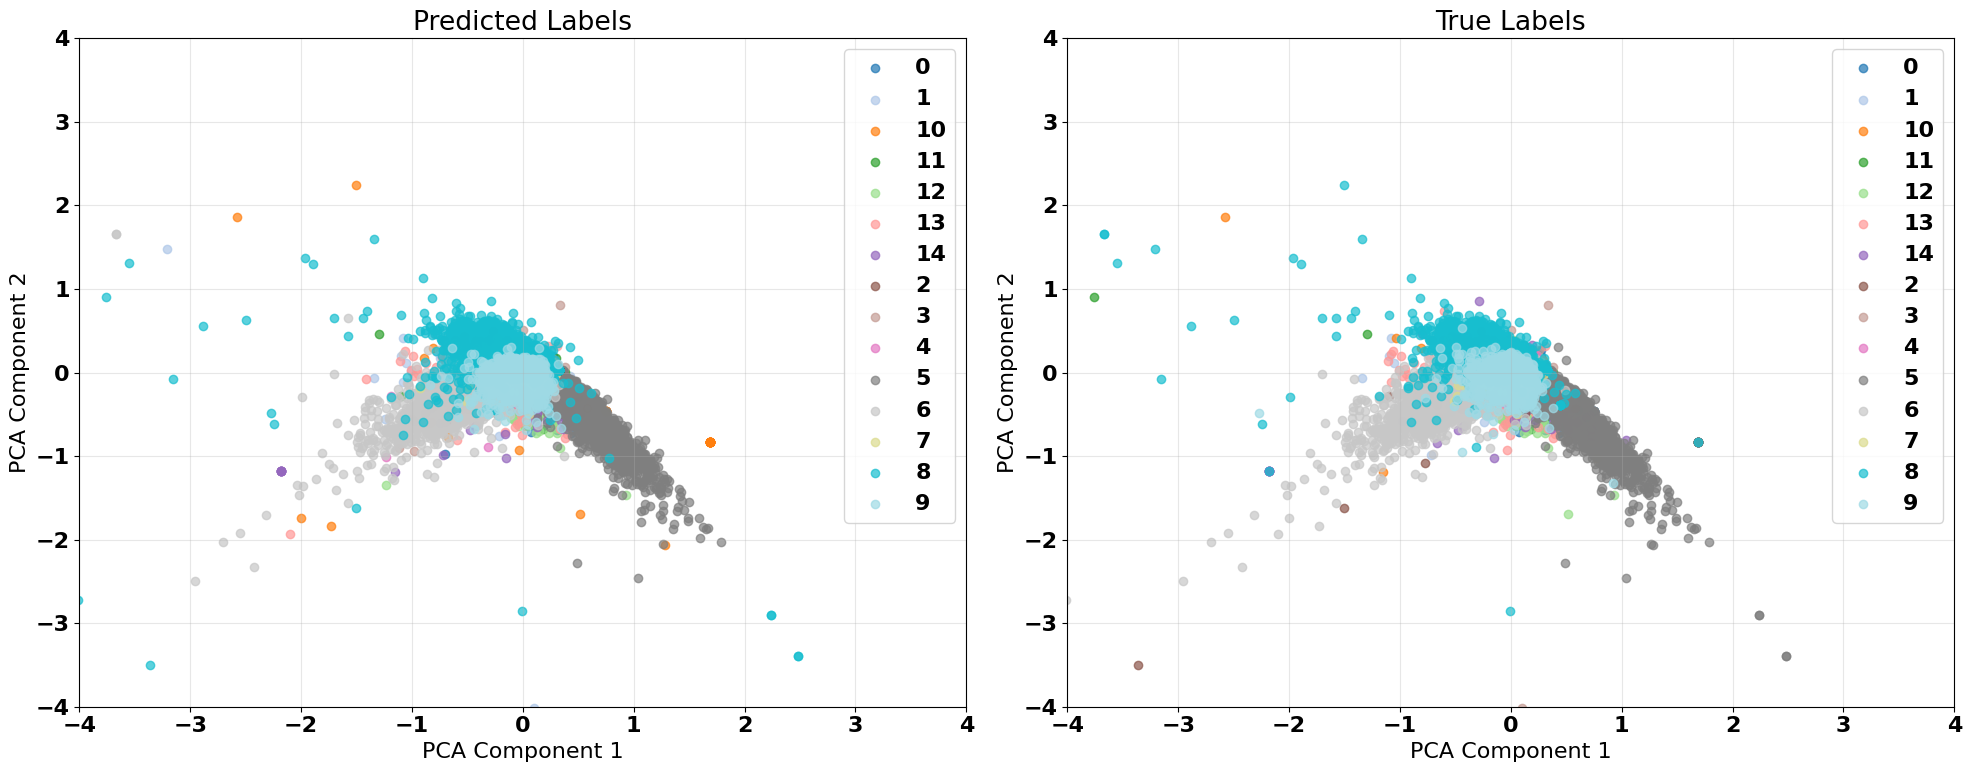

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First subplot - Predicted Labels
unique_labels_pred = sorted(set(predicted_labels))
colors_pred = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_pred)))

for i, label in enumerate(unique_labels_pred):
    indices = [j for j, l in enumerate(predicted_labels) if l == label]
    points = reduced_vectors[indices]
    ax1.scatter(points[:, 0], points[:, 1], color=colors_pred[i], label=label, alpha=0.7)

ax1.set_title("Predicted Labels")
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)

# Second subplot - True Labels
unique_labels_true = sorted(set(true_labels))
colors_true = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_true)))

for i, label in enumerate(unique_labels_true):
    indices = [j for j, l in enumerate(true_labels) if l == label]
    points = reduced_vectors[indices]
    ax2.scatter(points[:, 0], points[:, 1], color=colors_true[i], label=label, alpha=0.7)

ax2.set_title("True Labels")
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/DCU/Machine Learning/labels_comparison.png', dpi=300)
plt.show()

# 6.Retraining all data for final test
> Retraining the model by combining train and val datasets, then predict on the final test set (predict top_category)

In [ ]:
# 1. Load the model
best_model = fasttext.load_model('/content/drive/My Drive/DCU/Machine Learning/top_category_best.bin')  # modify path as needed

In [ ]:
best_model.test(test_file)

(45925, 0.8994011976047904, 0.8994011976047904)

In [ ]:
# Best parameters
# model3 = fasttext.train_supervised(
#     input='/content/drive/My Drive/DCU/Machine Learning/all_columns.train',
#     lr = 1.5,
#     dim = 70,
#     epoch = 6,
#     ws = 6,
#     wordNgrams = 3,
#     loss = 'ova'

# )

In [ ]:
df_train.shape

(229624, 30)

In [ ]:
df_train.iloc[0][-1]

<ipython-input-207-fa648131a1e0>:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



'__label__8 driftwood solar lamp handcrafted off grid solar night light garden driftwood solar light gazebo light sleep camp light free shipping in canada and the usa this one of a kind solar driftwood lamp is ready for any setting such as a garden cottage sun room sleep camp off grid and any nautical decor it is 15 5 inches tall by 10 inches long absolutely beautiful piece of artwork if you have any questions please feel free to contact me anytime driftwood lamp driftwood solar nautical cottage decor unique one of a kind handcrafted off grid garden decor farmhouse decor house boat decor solar garden store physical patio outdoor wood'

In [ ]:
df_train.iloc[0]

,0
product_id,1500855633
title,Driftwood Solar Lamp Handcrafted Off Grid Sola...
description,Free shipping in Canada and the USA. This one...
tags,"Driftwood Lamp,driftwood solar,nautical,cottag..."
type,physical
room,patio & outdoor
craft_type,
recipient,
material,wood
occasion,


In [ ]:
#df_train['description2_to_target']
df_train.to_csv("/content/drive/My Drive/DCU/Machine Learning/all_data.retrain", columns=['description2_to_target'], index=False, header=False)

In [ ]:
# Read the file back
df_check = pd.read_csv("/content/drive/My Drive/DCU/Machine Learning/all_data.retrain", header=None, names=['content'])

# Display the first few rows to verify
print("First 5 rows of the saved file:")
print(df_check.head())

First 5 rows of the saved file:
                                             content
0  __label__8 driftwood solar lamp handcrafted of...
1  __label__8 coconut bistro patio light hand car...
2  __label__8 garden outdoor lamp for meditation ...
3  __label__8 sunflower solar mason jar light sol...
4  __label__8 nwt rae dunn queen pool lounger gor...


In [ ]:
# Best parameters
final_model = fasttext.train_supervised(
    input='/content/drive/My Drive/DCU/Machine Learning/all_data.retrain',
    lr = 1.5,
    dim = 70,
    epoch = 6,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'

)

In [ ]:
df_test.iloc[0]

,0
product_id,1397234990
title,Antler Skull Deer Skull Hand Painted Beads Dec...
description,Hand painted deer antlers.\nThe skull is natur...
tags,
type,physical
room,
craft_type,
recipient,
material,
occasion,


In [ ]:
df_test['all_features'] = df_test.apply(combine_all_features, axis=1)
df_test['processed_text_all'] = df_test['all_features'].apply(preprocess_text)

In [ ]:
df_test.iloc[0]

,0
product_id,1397234990
title,Antler Skull Deer Skull Hand Painted Beads Dec...
description,Hand painted deer antlers.\nThe skull is natur...
tags,
type,physical
room,
craft_type,
recipient,
material,
occasion,


In [ ]:
df_test.iloc[0][-1]

<ipython-input-222-38a3434af36a>:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



'antler skull deer skull hand painted beads decoration wall decoration witch wicca halloween boho ethnic table decoration bone deer statement hand painted deer antlers nthe skull is natural with a gravestone and die young painting the bars have been blackened nbeautifully unique without suspension n n n i only use very old antlers no animal has to be killed separately physical'

In [ ]:
label = final_model.predict(["sunflower solar mason jar"])[0][0][0]
label

'__label__10'

In [ ]:
label_no = label.replace("__label__", "")
label_no

'10'

In [ ]:
df_test['top_category_id'] = df_test['processed_text_all'].apply(
    lambda x: final_model.predict([x])[0][0][0].replace('__label__', '')
)

In [ ]:
df_test.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern,all_features,processed_text_all,top_category_id
0,1397234990,Antler Skull Deer Skull Hand Painted Beads Dec...,Hand painted deer antlers.\nThe skull is natur...,,physical,,,,,,,,,,,Antler Skull Deer Skull Hand Painted Beads Dec...,antler skull deer skull hand painted beads dec...,8
1,1167322940,Hemifusus Conchilidium - Collectible Shell Spe...,Measures 2.625 x 1.625 x 1.25 inches.\n\nSeash...,"small conch,hemifusus,orange,orange shell,spir...",physical,,,,,,,,,,,Hemifusus Conchilidium - Collectible Shell Spe...,hemifusus conchilidium collectible shell speci...,8
2,1346575470,Excavation set with real bones / hammer chisel...,Discovery fun for young and old!\nThere are RE...,,physical,,,,,,,,,,,Excavation set with real bones / hammer chisel...,excavation set with real bones hammer chisel b...,13
3,1607587430,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,"For sale is this glass filled with moss, pine ...",,physical,,,,,,,,,,,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,rabbit 39 s paw rabbit foot paw claw glass dec...,8
4,1633456300,Coyote Tooth and Freshwater Pearl Ornament | S...,Coyote Tooth and Freshwater Pearl Ornament 🌸\n...,"ostara,oddities,pagan art,goblincore,forest wi...",physical,,,,,birthday,,,,,,Coyote Tooth and Freshwater Pearl Ornament | S...,coyote tooth and freshwater pearl ornament spr...,8


In [ ]:
df_test.to_csv('/content/drive/My Drive/DCU/Machine Learning/final_top_label_result.test')

NameError: name 'df_test' is not defined

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/My Drive/DCU/Machine Learning/final/final_top_label_result.test')

In [ ]:
df.head()

,Unnamed: 0,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern,all_features,processed_text_all,top_category_id
0,0,1397234990,Antler Skull Deer Skull Hand Painted Beads Dec...,Hand painted deer antlers.\nThe skull is natur...,NaN,physical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Antler Skull Deer Skull Hand Painted Beads Dec...,antler skull deer skull hand painted beads dec...,8
1,1,1167322940,Hemifusus Conchilidium - Collectible Shell Spe...,Measures 2.625 x 1.625 x 1.25 inches.\n\nSeash...,"small conch,hemifusus,orange,orange shell,spir...",physical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hemifusus Conchilidium - Collectible Shell Spe...,hemifusus conchilidium collectible shell speci...,8
2,2,1346575470,Excavation set with real bones / hammer chisel...,Discovery fun for young and old!\nThere are RE...,NaN,physical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Excavation set with real bones / hammer chisel...,excavation set with real bones hammer chisel b...,13
3,3,1607587430,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,"For sale is this glass filled with moss, pine ...",NaN,physical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,rabbit 39 s paw rabbit foot paw claw glass dec...,8
4,4,1633456300,Coyote Tooth and Freshwater Pearl Ornament | S...,Coyote Tooth and Freshwater Pearl Ornament 🌸\n...,"ostara,oddities,pagan art,goblincore,forest wi...",physical,NaN,NaN,NaN,NaN,birthday,NaN,NaN,NaN,NaN,NaN,Coyote Tooth and Freshwater Pearl Ornament | S...,coyote tooth and freshwater pearl ornament spr...,8


In [ ]:
df.shape

(25514, 19)